Following are the codes used for the project:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14}) 
# to make the plots in the exported pdf look nicer
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

/var/folders/jk/6432tj595yb284sg3h1nftwr0000gn/T/ipykernel_21218/2970370244.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png','pdf')


In [14]:
# You don't need to run this cell if you are using the StochSS environment.
# However, if you are working in Google Colab or any other platform, you must run this cell to install gillespy2 first.

%pip install gillespy2

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import gillespy2
import matplotlib.pyplot as plt
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event, ODESolver

In [26]:
class Circadian_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Circadian_Oscillator")
        self.volume = 1

        # Define the parameters of the system
        self.add_parameter(Parameter(name="alpha", expression=50))     # Basal rate of transcription for A
        self.add_parameter(Parameter(name="alpha_prime", expression=500))  # Activated rate of transcription for A
        self.add_parameter(Parameter(name="alpha_R", expression=0.01))   # Basal rate of transcription for R
        self.add_parameter(Parameter(name="alpha_R_prime", expression=50))  # Activated rate of transcription for R
        self.add_parameter(Parameter(name="beta_A", expression=50))  # Translation rate for A
        self.add_parameter(Parameter(name="beta_R", expression=5))  # Translation rate for R
        self.add_parameter(Parameter(name="delta_MA", expression=10))  # Degradation rate of mRNA A
        self.add_parameter(Parameter(name="delta_MR", expression=0.5))  # Degradation rate of mRNA R
        self.add_parameter(Parameter(name="delta_A", expression=1))  # Degradation rate of A
        self.add_parameter(Parameter(name="delta_R", expression=0.2))  # Degradation rate of R
        self.add_parameter(Parameter(name="gamma_A", expression=1))  # Binding rate of A to other components
        self.add_parameter(Parameter(name="gamma_R", expression=1))  # Binding rate of R to other components
        self.add_parameter(Parameter(name="gamma_C", expression=2))  # Unbinding rate of A from other components
        self.add_parameter(Parameter(name="theta_A", expression=50))
        self.add_parameter(Parameter(name="theta_R", expression=100))

        # Add species and define the initial condition (count or concentration) of each species
        self.add_species(Species(name="DA", initial_value=1, mode="discrete"))  # Number of activator genes with A bound to its promoter
        self.add_species(Species(name="DA_prime", initial_value=0, mode="discrete"))  # Number of activator genes without A bound to its promoter
        self.add_species(Species(name="DR", initial_value=1, mode="discrete"))  # Number of repressor genes with R bound to its promoter
        self.add_species(Species(name="DR_prime", initial_value=0, mode="discrete"))  # Number of repressor genes without R bound to its promoter
        self.add_species(Species(name="MA", initial_value=0, mode="discrete"))  # mRNA of A
        self.add_species(Species(name="MR", initial_value=0, mode="discrete"))  # mRNA of R
        self.add_species(Species(name="A", initial_value=0, mode="discrete"))  # Activator protein
        self.add_species(Species(name="R", initial_value=0, mode="discrete"))  # Repressor protein
        self.add_species(Species(name="C", initial_value=0, mode="discrete"))  # Inactivated complex formed by A and R

        # Reactions
        self.add_reaction(Reaction(name="r1", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_C"]))
        self.add_reaction(Reaction(name="r2", reactants={'A': 1}, products={}, rate=self.listOfParameters["delta_A"]))
        self.add_reaction(Reaction(name="r3", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_A"]))
        self.add_reaction(Reaction(name="r4", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_R"]))
        self.add_reaction(Reaction(name="r5", reactants={'DA': 1, 'A': 1}, products={'DA_prime': 1}, rate=self.listOfParameters["gamma_A"]))
        self.add_reaction(Reaction(name="r6", reactants={'DR': 1, 'A': 1}, products={'DR_prime': 1}, rate=self.listOfParameters["gamma_R"]))
        self.add_reaction(Reaction(name="r7", reactants={'DA_prime': 1}, products={'DA': 1, 'A':1}, rate=self.listOfParameters["theta_A"]))
        self.add_reaction(Reaction(name="r8", reactants={'DA': 1}, products={'DA': 1, 'MA':1}, rate=self.listOfParameters["alpha"]))
        self.add_reaction(Reaction(name="r9", reactants={'DA_prime': 1}, products={'DA_prime': 1, 'MA':1}, rate=self.listOfParameters["alpha_prime"]))
        self.add_reaction(Reaction(name="r10", reactants={'MA': 1}, products={}, rate=self.listOfParameters["delta_MA"]))
        self.add_reaction(Reaction(name="r11", reactants={'MA': 1}, products={'A': 1, 'MA': 1}, rate=self.listOfParameters["beta_A"]))
        self.add_reaction(Reaction(name="r12", reactants={'DR_prime': 1}, products={'DR': 1, "A":1}, rate=self.listOfParameters["theta_R"]))
        self.add_reaction(Reaction(name="r13", reactants={'DR': 1}, products={'DR': 1, 'MR':1}, rate=self.listOfParameters["alpha_R"]))
        self.add_reaction(Reaction(name="r14", reactants={'DR_prime': 1}, products={'DR_prime': 1, 'MR':1}, rate=self.listOfParameters["alpha_R_prime"]))
        self.add_reaction(Reaction(name="r15", reactants={'MR': 1}, products={}, rate=self.listOfParameters["delta_MR"]))
        self.add_reaction(Reaction(name="r16", reactants={'MR': 1}, products={'R': 1, 'MR': 1}, rate=self.listOfParameters["beta_R"]))

        # Timespan
        self.timespan(np.linspace(0, 400, 3000))

In [27]:
model = Circadian_Oscillator()
model.timespan(np.linspace(0, 400, 3000))  # Set appropriate timespan
# Run the simulation using the ODE solver
# Choose and set up the ODE solver
results = model.run(algorithm="ODE")

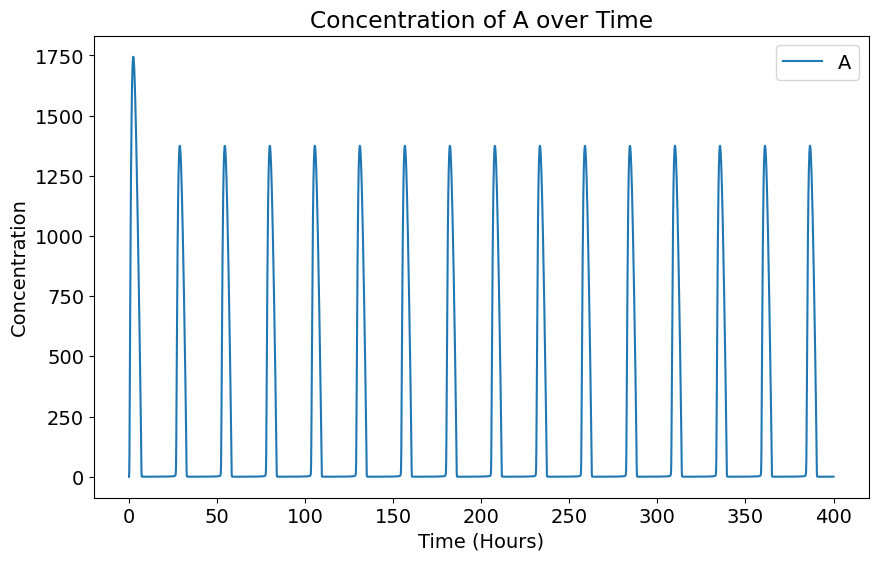

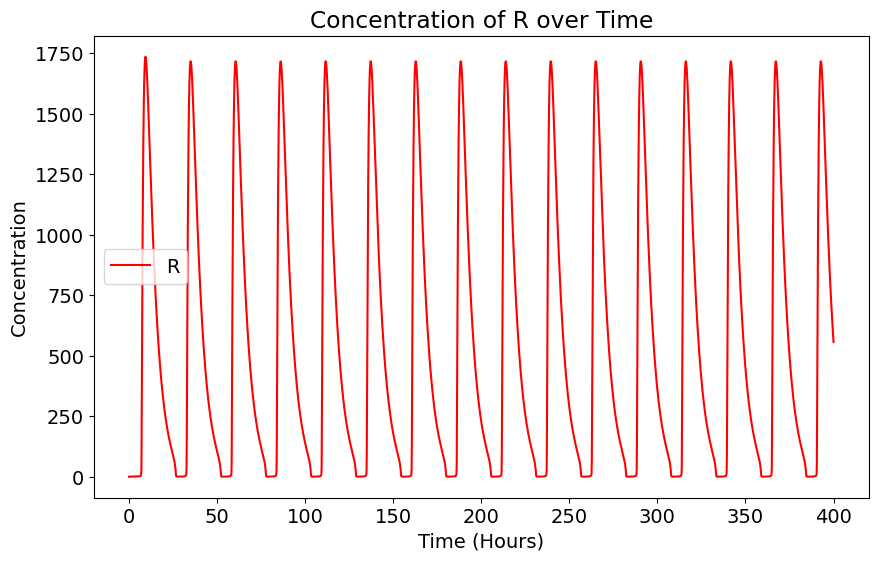

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['A'], label='A')
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration')
plt.title('Concentration of A over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['R'], label='R', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration')
plt.title('Concentration of R over Time')
plt.legend()
plt.show()

In [31]:
model = Circadian_Oscillator()
results = model.run(algorithm = "SSA")

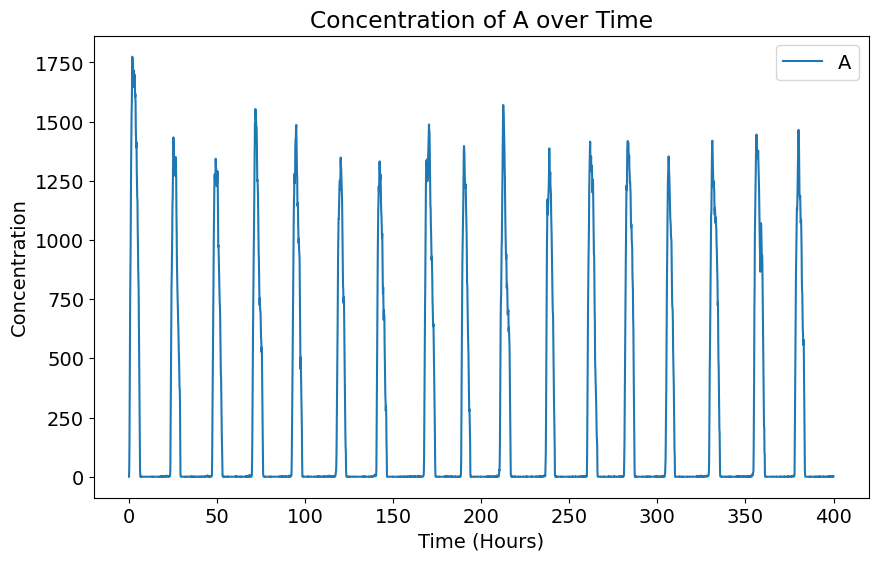

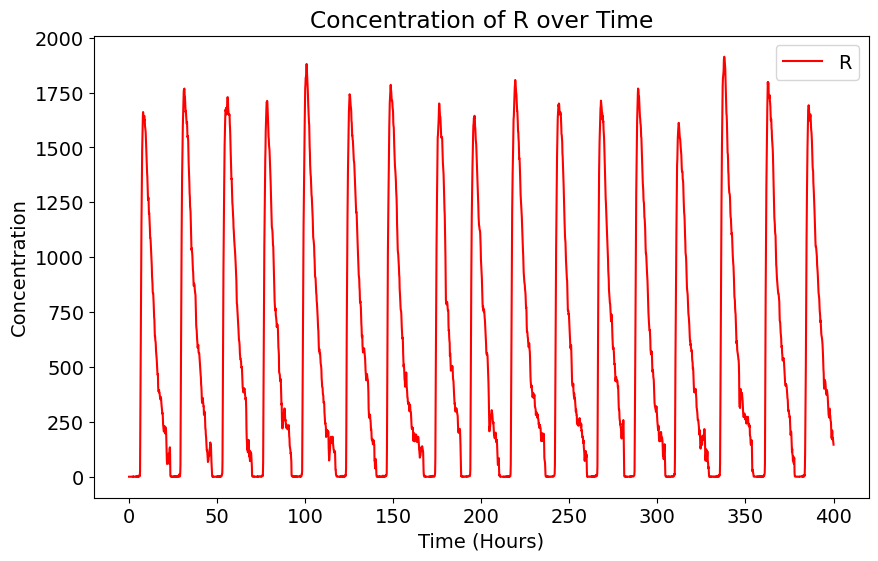

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['A'], label='A')
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration')
plt.title('Concentration of A over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['R'], label='R', color='red')
plt.xlabel('Time (Hours)')
plt.ylabel('Concentration')
plt.title('Concentration of R over Time')
plt.legend()
plt.show()

In [21]:
class Circadian_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Circadian_Oscillator")
        self.volume = 1

        # Define the parameters of the system
        self.add_parameter(Parameter(name="alpha", expression=50))     # Basal rate of transcription for A
        self.add_parameter(Parameter(name="alpha_prime", expression=500))  # Activated rate of transcription for A
        self.add_parameter(Parameter(name="alpha_R", expression=0.01))   # Basal rate of transcription for R
        self.add_parameter(Parameter(name="alpha_R_prime", expression=50))  # Activated rate of transcription for R
        self.add_parameter(Parameter(name="beta_A", expression=50))  # Translation rate for A
        self.add_parameter(Parameter(name="beta_R", expression=5))  # Translation rate for R
        self.add_parameter(Parameter(name="delta_MA", expression=10))  # Degradation rate of mRNA A
        self.add_parameter(Parameter(name="delta_MR", expression=0.5))  # Degradation rate of mRNA R
        self.add_parameter(Parameter(name="delta_A", expression=1))  # Degradation rate of A
        self.add_parameter(Parameter(name="delta_R", expression=0.05))  # Degradation rate of R
        self.add_parameter(Parameter(name="gamma_A", expression=1))  # Binding rate of A to other components
        self.add_parameter(Parameter(name="gamma_R", expression=1))  # Binding rate of R to other components
        self.add_parameter(Parameter(name="gamma_C", expression=2))  # Unbinding rate of A from other components
        self.add_parameter(Parameter(name="theta_A", expression=50))
        self.add_parameter(Parameter(name="theta_R", expression=100))

        # Add species and define the initial condition (count or concentration) of each species
        self.add_species(Species(name="DA", initial_value=1, mode="discrete"))  # Number of activator genes with A bound to its promoter
        self.add_species(Species(name="DA_prime", initial_value=0, mode="discrete"))  # Number of activator genes without A bound to its promoter
        self.add_species(Species(name="DR", initial_value=1, mode="discrete"))  # Number of repressor genes with R bound to its promoter
        self.add_species(Species(name="DR_prime", initial_value=0, mode="discrete"))  # Number of repressor genes without R bound to its promoter
        self.add_species(Species(name="MA", initial_value=0, mode="discrete"))  # mRNA of A
        self.add_species(Species(name="MR", initial_value=0, mode="discrete"))  # mRNA of R
        self.add_species(Species(name="A", initial_value=0, mode="discrete"))  # Activator protein
        self.add_species(Species(name="R", initial_value=0, mode="discrete"))  # Repressor protein
        self.add_species(Species(name="C", initial_value=0, mode="discrete"))  # Inactivated complex formed by A and R

        # Reactions
        self.add_reaction(Reaction(name="r1", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_C"]))
        self.add_reaction(Reaction(name="r2", reactants={'A': 1}, products={}, rate=self.listOfParameters["delta_A"]))
        self.add_reaction(Reaction(name="r3", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_A"]))
        self.add_reaction(Reaction(name="r4", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_R"]))
        self.add_reaction(Reaction(name="r5", reactants={'DA': 1, 'A': 1}, products={'DA_prime': 1}, rate=self.listOfParameters["gamma_A"]))
        self.add_reaction(Reaction(name="r6", reactants={'DR': 1, 'A': 1}, products={'DR_prime': 1}, rate=self.listOfParameters["gamma_R"]))
        self.add_reaction(Reaction(name="r7", reactants={'DA_prime': 1}, products={'DA': 1, 'A':1}, rate=self.listOfParameters["theta_A"]))
        self.add_reaction(Reaction(name="r8", reactants={'DA': 1}, products={'DA': 1, 'MA':1}, rate=self.listOfParameters["alpha"]))
        self.add_reaction(Reaction(name="r9", reactants={'DA_prime': 1}, products={'DA_prime': 1, 'MA':1}, rate=self.listOfParameters["alpha_prime"]))
        self.add_reaction(Reaction(name="r10", reactants={'MA': 1}, products={}, rate=self.listOfParameters["delta_MA"]))
        self.add_reaction(Reaction(name="r11", reactants={'MA': 1}, products={'A': 1, 'MA': 1}, rate=self.listOfParameters["beta_A"]))
        self.add_reaction(Reaction(name="r12", reactants={'DR_prime': 1}, products={'DR': 1, "A":1}, rate=self.listOfParameters["theta_R"]))
        self.add_reaction(Reaction(name="r13", reactants={'DR': 1}, products={'DR': 1, 'MR':1}, rate=self.listOfParameters["alpha_R"]))
        self.add_reaction(Reaction(name="r14", reactants={'DR_prime': 1}, products={'DR_prime': 1, 'MR':1}, rate=self.listOfParameters["alpha_R_prime"]))
        self.add_reaction(Reaction(name="r15", reactants={'MR': 1}, products={}, rate=self.listOfParameters["delta_MR"]))
        self.add_reaction(Reaction(name="r16", reactants={'MR': 1}, products={'R': 1, 'MR': 1}, rate=self.listOfParameters["beta_R"]))

        # Timespan
        self.timespan(np.linspace(0, 400, 3000))

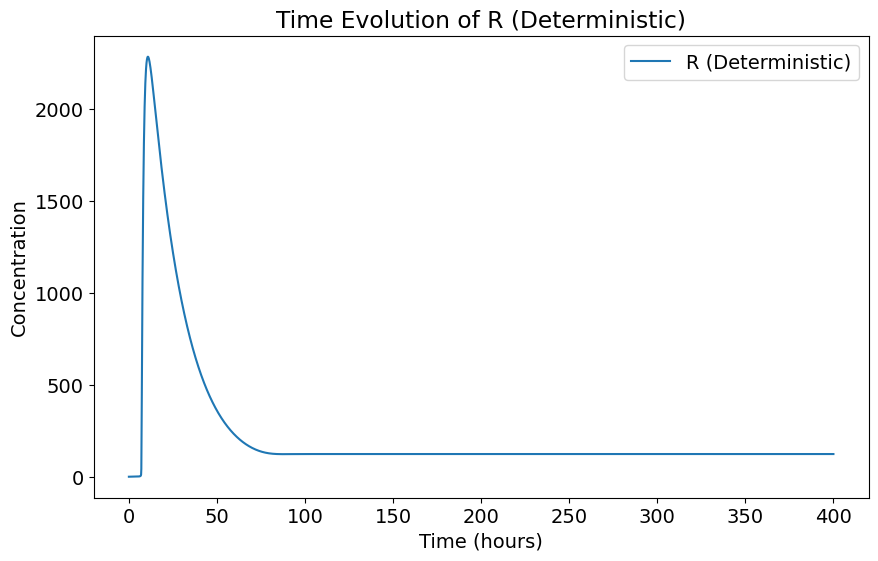

In [22]:
# Create an instance of the deterministic model
model_deterministic = Circadian_Oscillator()

# Choose and set up the ODE solver
solver_deterministic = ODESolver(model=model_deterministic)

# Run the deterministic simulation
results_deterministic = solver_deterministic.run()

# Extract simulation data
timepoints_det = results_deterministic['time']
R_values_det = results_deterministic['R']

# Plot the deterministic simulation results
plt.figure(figsize=(10, 6))
plt.plot(timepoints_det, R_values_det, label='R (Deterministic)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Time Evolution of R (Deterministic)')
plt.legend()
plt.show()

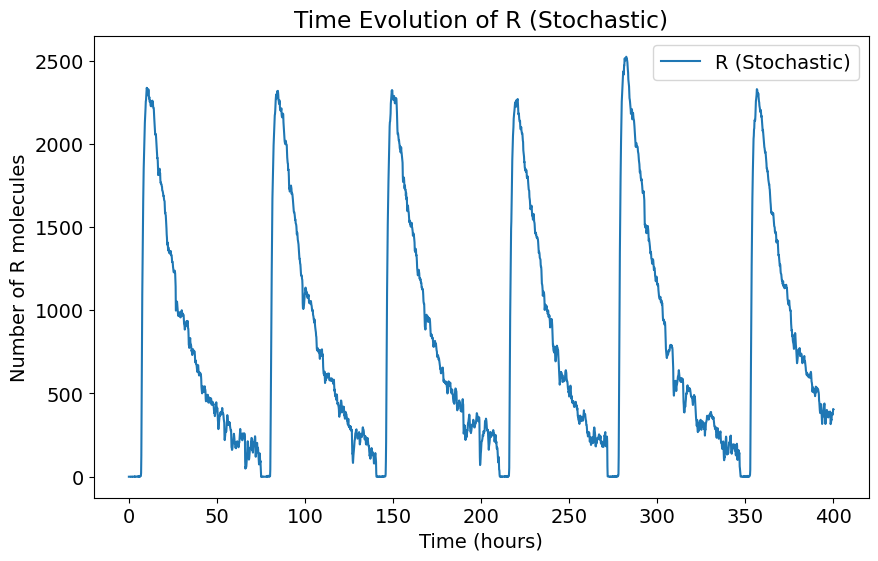

In [23]:
# Create an instance of the stochastic model
model_stochastic = Circadian_Oscillator()

# Run the stochastic simulation
results_stochastic =  model_stochastic.run(algorithm = "SSA")

# Extract simulation data
timepoints_stoch = results_stochastic['time']
R_values_stoch = results_stochastic['R']

# Plot the stochastic simulation results
plt.figure(figsize=(10, 6))
plt.plot(timepoints_stoch, R_values_stoch, label='R (Stochastic)')
plt.xlabel('Time (hours)')
plt.ylabel('Number of R molecules')
plt.title('Time Evolution of R (Stochastic)')
plt.legend()
plt.show()